In [1]:
push!(LOAD_PATH, "..")
using ASE, Potentials, MatSciPy, AtomsInterface, TestAtoms, TightBinding
using PyPlot
import AtOptim
import AtPrecon

In [3]:
# reference configuration
at = bulk("Al"; cubic=true)
at = repeat(at, (3, 3, 2))
set_pbc!(at, (false, false, false))
X0 = positions(at);
# jiggle the positions
# set_positions!(at, X0+0.01 * rand(size(X0)))
# create a calculator
r0 = rnn("Al")
rcut = 2.5 * r0
calc = MatSciPy.PairCalculator( SWCutoff( LennardJonesPotential(r0, 1.0), rcut, 1.0 ) )
# calc = TightBinding.ToyTB.ToyTBModel(r0=r0, rcut=rcut)
# TestAtoms.test_potentialenergy(calc, at)
# plot3D(X0[1,:][:], X0[2,:][:], X0[3,:][:], "b.")

MatSciPy.PairCalculator(Potentials.SWCutoff(Potentials.LennardJonesPotential(2.8637824638055176,1.0),7.159456159513794,1.0))

In [4]:
at = repeat(bulk("Al"; cubic=true), (10,10,2))
println(" #at = ", length(at))
# precon = AtPrecon.IdPrecon()
precon = AtPrecon.ExpPrecon(at, calc)
X0 = positions(at)
srand(12345)
set_positions!(at, X0+0.05 * rand(size(X0)))
@time AtOptim.minimise!(at, calc, 1e-5; precon=precon, disp=3, maxnit=100);

 #at = 800
-------|---------------------------------------------------------
 nit   |   ΔE        |∇E|∞     |Δx|∞      α        #E 
-------|---------------------------------------------------------
     1 | -5.41e+03  1.80e+00  0.00e+00  1.00e+00      1 
     2 | -6.76e+00  4.95e-01  1.14e-01  1.00e+00      2 
     3 | -6.26e-01  2.03e-01  2.41e-01  9.63e-01      3 
     4 | -1.68e-01  1.14e-01  1.80e-01  1.13e+00      4 
     5 | -5.80e-02  5.27e-02  1.66e-01  1.68e+00      5 
     6 | -8.30e-03  4.36e-02  1.24e-01  1.91e+00      6 
     7 | -3.11e-03  2.05e-02  9.77e-02  1.08e+00      7 
     8 | -7.20e-04  8.23e-03  4.34e-02  7.91e-01      8 
     9 | -1.79e-04  6.09e-03  9.91e-02  8.21e-01      9 
    10 | -2.21e-04  8.34e-04  4.71e-01  2.90e+00     10 
    11 | -4.44e-06  4.24e-04  1.82e-01  3.19e+00     11 
    12 | -4.89e-07  9.99e-05  1.33e-01  8.17e-01     13 
    13 | -5.18e-08  5.60e-05  6.90e-02  7.67e-01     14 
    14 | -5.85e-08  3.29e-05  1.59e-01  1.53e+00     15 
    

In [9]:
at = repeat(bulk("Al"; cubic=true), (3, 3, 2))
println(" #at = ", length(at))
X0 = positions(at)
srand(12345)
set_positions!(at, X0+0.05 * rand(size(X0)))
calc = TightBinding.ToyTB.ToyTBModel(r0=r0, rcut=rcut)
calc.nkpoints = (0,0,2)
TestAtoms.test_potentialenergy(calc, at)
@time precon = AtPrecon.ExpPrecon(at, calc); precon.cstab = 0.1
# precon = AtPrecon.IdPrecon()
AtOptim.minimise!(at, calc, 1e-4; precon=precon, disp=3, maxnit=100);

 #at = 72
-----------------------------
  p | error 
----|------------------------
  2 | 1.0090802e-03 
  3 | 1.0092990e-04 
  4 | 1.0093127e-05 
  5 | 1.0102944e-06 
  6 | 1.1723648e-07 
  7 | 2.0862872e-07 
  8 | 1.6218559e-06 
  9 | 1.8961699e-05 
 10 | 1.7189014e-04 
-----------------------------
  0.605043 seconds (1.49 M allocations: 69.621 MB, 2.62% gc time)
-------|---------------------------------------------------------
 nit   |   ΔE        |∇E|∞     |Δx|∞      α        #E 
-------|---------------------------------------------------------
     1 | -2.44e+01  1.17e-02  0.00e+00  1.00e+00      1 
     2 | -3.91e-03  3.46e-03  3.74e-01  4.11e-01      3 
     3 | -3.81e-04  1.83e-03  3.00e-01  3.81e-01      4 
     4 | -1.31e-04  1.07e-03  1.47e-01  4.05e-01      5 
     5 | -9.31e-05  7.38e-04  2.80e-01  6.60e-01      6 
     6 | -6.08e-05  6.82e-04  5.11e-01  8.87e-01      7 
     7 | -3.22e-05  6.16e-04  4.60e-01  4.63e-01      8 
     8 | -1.88e-05  5.92e-04  3.28e-01  2.44e-

In [10]:
function dist_from_X0(X, X0)
    R0 = X0[:, 2:4] .- X0[:,1]
    R = X[:, 2:4] .- X[:,1]
    # Q * R = R0 ⇔ Q = R0 / R
    Q = R0 / R
    X0 = X0 .- X0[:,1]
    X = X .- X[:,1]
    X = Q * X
    return sqrt(maximum(sumabs2(X0-X)))
end

function mini_precon(at, rcut)
    i, j = MatSciPy.neighbour_list(at, "ij", rcut)
    v = ones(length(i))
    P = sparse(i, i, v) - sparse(i, j, v) + 0.01 * speye(length(at))
end

mini_precon (generic function with 1 method)

In [15]:
# minimalistic static steepest descent to make sure it isn't a bug in minimise!
# the following suggests that it might be all due to either a bug in precon,
# or an awful numerical instability in TB energy evaluation.

import TightBinding.NRLTB

at = repeat(bulk("Al"; cubic=true), (5, 5, 1))
r0 = rnn("Al")
println(" #at = ", length(at), "; r0 = ", r0)
X0 = positions(at)
srand(12345)
set_positions!(at, X0+0.05 * rand(size(X0)))
# calc = TightBinding.ToyTB.ToyTBModel(r0=r0, rcut=rcut)
calc = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
calc.nkpoints = (0,0,0)
# precon = AtPrecon.ExpPrecon(at, calc); precon.cstab = 0.01; alpha = 0.03
# precon = AtPrecon.IdPrecon(); alpha = 0.1
P = mini_precon(at, 1.1*r0); alpha = 1.0e-3
X = copy(X0)
for n = 1:100
    frc = forces(at, calc)
    frcP = (lufact(P) \ frc')'
    @printf(" |frc|∞ = %4.2e ; |frc|_P⁻¹ = %4.2e  ;  |X-X0|∞ = %4.2e \n", 
            vecnorm(frc, Inf), sqrt(vecdot(frc, frcP)), dist_from_X0(X0, X) )
    X += alpha * (frcP)
    set_positions!(at, X)
end

# plot(X[1,:][:], X[2,:][:], "b.")

 #at = 100; r0 = 2.8637824638055176
 |frc|∞ = 1.26e-02 ; |frc|_P⁻¹ = 1.66e-02  ;  |X-X0|∞ = 0.00e+00 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4.56e-07 ; |frc|_P⁻¹ = 5.66e-07  ;  |X-X0|∞ = 3.30e-05 
 |frc|∞ = 4

LoadError: LoadError: InterruptException:
while loading In[15], in expression starting on line 20

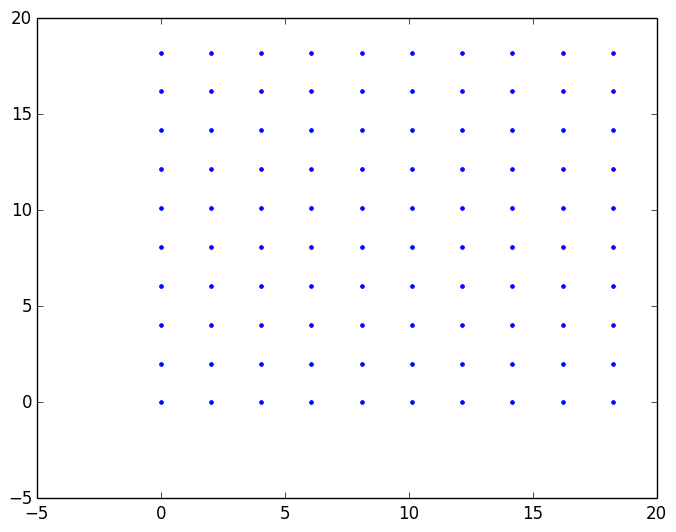

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x507b2d0>

In [16]:
plot(X[1,:][:], X[2,:][:], "b.")